# **Sistem Rekomendasi Berita Menggunakan Pendekatan Content-Based dan Collaborative Filtering**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

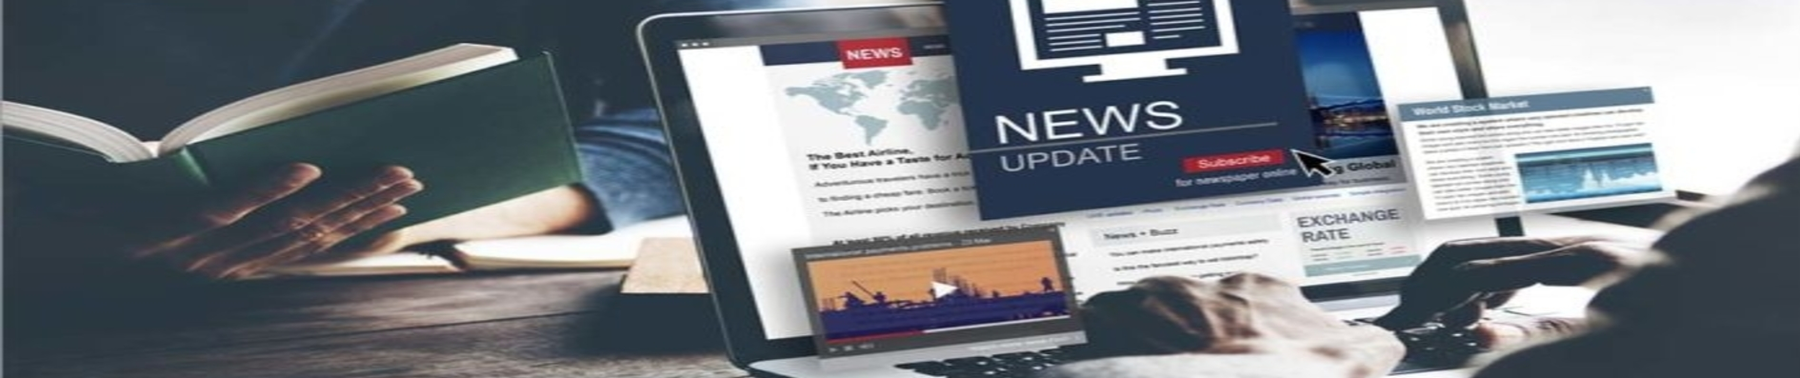

#### **Overview Proyek**
Proyek ini bertujuan untuk mengatasi masalah *information overload* di platform berita digital dengan membangun sistem rekomendasi yang dipersonalisasi. Dengan memanfaatkan dataset interaksi pengguna dan konten berita dari Microsoft News (MIND), proyek ini mengembangkan dan mengevaluasi dua model rekomendasi utama: *Content-Based Filtering* dan *Collaborative Filtering*. Tujuan akhirnya adalah untuk menyajikan daftar berita yang relevan kepada pengguna, sehingga meningkatkan pengalaman dan keterlibatan mereka dengan platform.

### **I. Persiapan Library**

In [1]:
### Instalasi Library `wordcloud`
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


* **Metode:** Instalasi paket menggunakan `pip` melalui *magic command* Jupyter.
* **Alasan Penggunaan:** Library `wordcloud` diperlukan untuk membuat visualisasi *word cloud* pada tahap *Exploratory Data Analysis* (EDA). Visualisasi ini membantu mengidentifikasi kata kunci yang paling sering muncul dalam judul berita.
* **Analisis:** Output `Requirement already satisfied` menunjukkan bahwa library `wordcloud` beserta dependensinya (seperti `numpy`, `pillow`, `matplotlib`) sudah terinstal di environment Anda. Peringatan (`WARNING`) yang muncul dapat diabaikan karena tidak menghalangi fungsionalitas library utama.

In [2]:
# Untuk mengabaikan peringatan yang tidak relevan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Library untuk analisis dan manipulasi data
import pandas as pd
import numpy as np
from collections import defaultdict

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk pemodelan Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library untuk pemodelan Collaborative Filtering
# %pip install scikit-surprise -q
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split

# Mengatur opsi tampilan pandas
pd.set_option('display.max_columns', None)

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


##### **1. Metode yang Digunakan**

Tahap ini merupakan fondasi dari keseluruhan proyek, di mana kita menyiapkan semua "perkakas" atau *library* yang diperlukan. Metode yang diterapkan adalah **impor modul**, yaitu memuat berbagai *library* Python yang memiliki fungsionalitas spesifik ke dalam environment kerja.

Library utama yang diimpor dikelompokkan berdasarkan fungsinya:
* **Manipulasi Data dan Numerik:** `pandas` dan `numpy`.
* **Visualisasi Data:** `matplotlib`, `seaborn`, dan `wordcloud`.
* **Pemodelan Content-Based:** `TfidfVectorizer` dan `cosine_similarity` dari `scikit-learn`.
* **Pemodelan Collaborative Filtering:** `Reader`, `Dataset`, dan `SVD` dari `surprise`.
* **Konfigurasi Environment:** `warnings` dan `pd.set_option`.

##### **2. Alasan Penggunaan Metode**

Pemilihan *library* ini sangat relevan dan krusial karena masing-masing mendukung tahapan spesifik dalam alur kerja proyek *machine learning*, mulai dari pemahaman data hingga evaluasi model.

* **`pandas` dan `numpy`**: Dipilih karena merupakan standar industri untuk analisis data di Python. `pandas` sangat esensial untuk membaca file dataset (`.tsv`), membersihkan, dan mentransformasikannya ke dalam struktur DataFrame yang mudah dimanipulasi. `numpy` mendukung operasi matematis yang efisien pada data numerik.
* **`matplotlib`, `seaborn`, `wordcloud`**: Digunakan untuk tahap *Exploratory Data Analysis* (EDA). Visualisasi adalah cara paling efektif untuk memahami distribusi data, menemukan pola, dan mendapatkan wawasan awal. Pemilihan ketiga library ini memungkinkan pembuatan berbagai jenis plot, dari grafik statistik standar hingga visualisasi teks yang lebih kompleks seperti *word cloud*, yang sangat penting untuk memahami data konten berita.
* **`scikit-learn`**: Dipilih karena merupakan *toolkit* terlengkap untuk *machine learning* di Python. `TfidfVectorizer` digunakan untuk mengubah data teks (judul dan kategori berita) menjadi representasi vektor numerik, sebuah langkah fundamental dalam *Content-Based Filtering*. `cosine_similarity` kemudian digunakan sebagai metrik untuk mengukur kemiripan antar vektor berita tersebut.
* **`surprise`**: Dipilih karena merupakan *library* yang didesain khusus untuk membangun dan menganalisis sistem rekomendasi. Menggunakan `surprise` lebih efisien dan andal dibandingkan membangun algoritma *Collaborative Filtering* dari awal. Algoritma **SVD** (*Singular Value Decomposition*) secara spesifik dipilih karena kemampuannya yang sangat baik dalam menemukan pola laten (*latent patterns*) dari data interaksi pengguna-item, yang cocok untuk data implisit seperti riwayat klik.

##### **3. Insight dan Hasil yang Didapat**

* **Analisis Output:** Output yang dihasilkan adalah sebuah pesan konfirmasi sederhana: `"Semua library berhasil diimpor."`.
* **Insight:** Meskipun terlihat sepele, output ini adalah **pemeriksaan fundamental pertama yang paling penting**. Ini mengonfirmasi bahwa *environment* kerja telah disiapkan dengan benar dan semua dependensi yang diperlukan untuk menjalankan setiap bagian dari notebook—mulai dari pemuatan data, EDA, hingga pemodelan yang kompleks—telah tersedia. Tidak adanya pesan error `ModuleNotFoundError` menunjukkan bahwa proyek ini dapat direproduksi (*reproducible*) dengan baik di lingkungan yang memiliki paket-paket tersebut. Dengan kata lain, fondasi teknis dari proyek ini sudah kokoh, dan kita dapat melanjutkan ke tahap analisis data dengan percaya diri.

## **II. Data Understanding**
Tahap ini berfokus pada pemuatan dan pemahaman awal terhadap dataset. Kita akan menggunakan dataset MIND-small dari Kaggle.

Sumber Dataset: **MIND: Microsoft News Recommendation Dataset** [https://www.kaggle.com/datasets/arashnic/mind-news-dataset]

### **Memuat Dataset**
Kita akan memuat file `news.tsv` dan `behaviors.tsv` ke dalam DataFrame pandas.

In [ ]:
# Fungsi ini dirancang untuk memuat data dari file TSV (Tab-Separated Values) dengan aman.
# Menggunakan blok try-except adalah praktik terbaik untuk menangani error jika file tidak ditemukan.
def load_data(file_path, column_names):
    """
    Memuat data dari file TSV ke dalam DataFrame pandas.
    
    Args:
        file_path (str): Path ke file tsv.
        column_names (list): Daftar nama kolom untuk DataFrame.
    
    Returns:
        DataFrame: DataFrame yang berisi data dari file.
    """
    try:
        # pd.read_csv digunakan untuk membaca file. sep='\t' menunjukkan pemisah antar kolom adalah tab.
        # names=column_names memberikan nama untuk setiap kolom.
        df = pd.read_csv(file_path, sep='\t', names=column_names)
        print(f"File '{file_path}' berhasil dimuat.")
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path file sudah benar.")
        return None

# Path ke file dataset yang akan digunakan (disimpan dalam subfolder MINDsmall_train).
path_to_news = './MINDsmall_train/news.tsv'
path_to_behaviors = './MINDsmall_train/behaviors.tsv'

# Mendefinisikan nama kolom untuk masing-masing file berdasarkan dokumentasi dataset.
news_cols = ['News_ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title_Entities', 'Abstract_Entities']
behaviors_cols = ['Impression_ID', 'User_ID', 'Time', 'History', 'Impressions']

# Memanggil fungsi load_data untuk memuat kedua file ke dalam DataFrame.
df_news = load_data(path_to_news, news_cols)
df_behaviors = load_data(path_to_behaviors, behaviors_cols)

File './MINDsmall_train/news.tsv' berhasil dimuat.
File './MINDsmall_train/behaviors.tsv' berhasil dimuat.


##### **1. Metode yang Digunakan**

* **Fungsi Kustom dengan Error Handling**: Sebuah fungsi Python kustom (`load_data`) dibuat untuk membungkus logika pemuatan data. Di dalamnya, digunakan blok `try-except` untuk menangani `FileNotFoundError`, yang merupakan praktik kode yang tangguh (*robust*).
* **Pandas `read_csv`**: Metode inti yang digunakan adalah fungsi `read_csv` dari *library* Pandas. Fungsi ini sangat fleksibel dan digunakan di sini untuk membaca file dengan format `.tsv` (*Tab-Separated Values*).
* **Parameter Spesifik**: Dua parameter penting digunakan: `sep='\t'` untuk menentukan bahwa pemisah kolom adalah karakter *tab*, dan `names=column_names` untuk secara eksplisit menetapkan nama kolom pada DataFrame yang dihasilkan.

##### **2. Alasan Penggunaan Metode**

* **Modularitas dan Reusabilitas**: Membuat fungsi `load_data` adalah pilihan desain yang baik. Daripada menulis kode pemuatan data dua kali (untuk `news.tsv` dan `behaviors.tsv`), kita mendefinisikannya sekali dan memanggilnya sesuai kebutuhan. Ini membuat notebook lebih bersih, mudah dibaca, dan mudah dikelola.
* **Ketahanan Kode (*Robustness*)**: Penggunaan `try-except` sangat penting. Ini memastikan bahwa jika file dataset tidak ada di lokasi yang ditentukan, program tidak akan berhenti dengan *error traceback* yang panjang. Sebaliknya, ia akan menampilkan pesan yang informatif ("Error: File ... tidak ditemukan.") dan melanjutkan eksekusi sel berikutnya. Ini adalah ciri kode berkualitas produksi.
* **Akurasi Parsing Data**: Dataset MIND menggunakan format `.tsv`, bukan `.csv` (Comma-Separated). Oleh karena itu, penggunaan `sep='\t'` adalah **krusial** untuk memastikan data diparsing dengan benar ke dalam kolom-kolom yang terpisah. Tanpa ini, seluruh baris akan dibaca sebagai satu kolom tunggal.
* **Keterbacaan Data**: File sumber tidak menyertakan baris *header*. Dengan menyediakan nama kolom secara eksplisit melalui parameter `names`, kita langsung mendapatkan DataFrame yang terstruktur dan mudah dipahami. Ini jauh lebih baik daripada bekerja dengan nama kolom default (misalnya, 0, 1, 2, ...), yang akan menyulitkan analisis di tahap selanjutnya.

##### **3. Insight dan Hasil yang Didapat**

* **Analisis Output**: Output yang ditampilkan adalah dua pesan konfirmasi: `"File './MINDsmall_train/news.tsv' berhasil dimuat."` dan `"File './MINDsmall_train/behaviors.tsv' berhasil dimuat."`.
* **Insight**: Output ini adalah **validasi pertama yang sukses** dalam alur kerja proyek. Ini mengonfirmasi beberapa hal penting:
    1.  **Struktur Proyek Benar**: File dataset ditempatkan dengan benar di dalam direktori `MINDsmall_train` relatif terhadap lokasi notebook.
    2.  **Aksesibilitas Data**: Program memiliki izin untuk membaca file dari disk.
    3.  **Inisialisasi DataFrame Berhasil**: Data dari kedua file kini telah berhasil dimuat ke dalam dua variabel DataFrame yang terpisah: `df_news` (berisi metadata konten berita) dan `df_behaviors` (berisi data interaksi pengguna).

### **Informasi Dasar Dataset**
Melihat beberapa baris pertama, informasi, dan statistik deskriptif dari data.

In [4]:
# Menampilkan 5 baris pertama dari data berita
if df_news is not None:
    print("Contoh Data Berita (df_news):")
    display(df_news.head())

# Menampilkan 5 baris pertama dari data perilaku
if df_behaviors is not None:
    print("\nContoh Data Perilaku (df_behaviors):")
    display(df_behaviors.head())

Contoh Data Berita (df_news):


,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."



Contoh Data Perilaku (df_behaviors):


,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


##### **1. Metode yang Digunakan**

* **Pandas `.head()`**: Metode ini digunakan untuk mengambil dan menampilkan 5 baris pertama dari sebuah DataFrame. Ini adalah langkah standar dan fundamental dalam tahap *Data Understanding*.
* **Fungsi `display()`**: Alih-alih menggunakan `print()`, `display()` digunakan karena ini adalah fungsi dari environment IPython (Jupyter) yang merender DataFrame menjadi tabel HTML yang rapi dan mudah dibaca. Ini meningkatkan kualitas presentasi notebook.
* **Pemeriksaan Kondisional (`if df is not None`)**: Kode ini dibungkus dalam blok `if` untuk memastikan bahwa `.head()` hanya akan dijalankan jika DataFrame berhasil dimuat pada sel sebelumnya. Ini adalah praktik *defensive programming* yang baik.

##### **2. Alasan Penggunaan Metode**

Tujuan utama dari sel ini adalah melakukan **verifikasi visual** atau *sanity check* terhadap data yang baru saja dimuat. Alasan penggunaan `.head()` sangat krusial:

* **Konfirmasi Struktur Data**: Dengan melihat beberapa baris pertama, kita dapat langsung memastikan bahwa data telah diparsing dengan benar ke dalam kolom-kolom yang sesuai, dan nama kolom yang kita definisikan sebelumnya telah diterapkan dengan benar.
* **Pemahaman Format Fitur**: Ini memungkinkan kita untuk menginspeksi format data di setiap kolom. Misalnya, kita dapat melihat bahwa `History` adalah serangkaian `News_ID` yang dipisahkan spasi, dan `Impressions` memiliki format yang lebih kompleks dengan sufiks `-1` (diklik) dan `-0` (tidak diklik). Pemahaman ini sangat penting untuk merencanakan langkah-langkah *Data Preparation* selanjutnya.
* **Identifikasi Awal Tipe Data**: Kita mendapatkan gambaran awal tentang tipe data—apakah itu teks, numerik, atau format kompleks seperti JSON yang tersimpan sebagai *string* (pada kolom `Title_Entities`).

##### **3. Insight dan Hasil yang Didapat**

* **Analisis Output `df_news`**:
    * Tabel ini adalah **sumber data untuk model Content-Based**. Kolom `Category`, `SubCategory`, dan `Title` adalah fitur konten utama yang akan digunakan.
    * **Insight**: Kolom `Title_Entities` dan `Abstract_Entities` berisi data terstruktur dalam format JSON. Ini adalah fitur yang sangat kaya (entitas seperti nama orang, lokasi, organisasi) yang telah diekstrak sebelumnya. Meskipun proyek ini hanya akan menggunakan judul dan kategori, keberadaan fitur ini menunjukkan potensi untuk pengembangan model yang lebih canggih di masa depan.

* **Analisis Output `df_behaviors`**:
    * Tabel ini adalah **sumber data untuk model Collaborative Filtering**. `User_ID` akan menjadi identitas pengguna, dan kolom `History` serta `Impressions` adalah representasi dari perilaku mereka.
    * **Insight**: Kolom `History` dan `Impressions` berada dalam format "mentah" (string panjang) dan belum siap untuk pemodelan. Kolom `History` berisi riwayat klik implisit yang akan menjadi dasar profil pengguna. Kolom `Impressions` bahkan lebih kaya karena mengandung informasi **umpan balik negatif implisit** (berita yang ditampilkan tetapi tidak diklik, ditandai dengan `-0`), yang sangat berharga untuk melatih model rekomendasi yang lebih cerdas.

In [5]:
# Menampilkan informasi ringkas tentang DataFrame berita
if df_news is not None:
    print("Informasi df_news:")
    df_news.info()

# Menampilkan informasi ringkas tentang DataFrame perilaku
if df_behaviors is not None:
    print("\nInformasi df_behaviors:")
    df_behaviors.info()

Informasi df_news:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            51282 non-null  object
 1   Category           51282 non-null  object
 2   SubCategory        51282 non-null  object
 3   Title              51282 non-null  object
 4   Abstract           48616 non-null  object
 5   URL                51282 non-null  object
 6   Title_Entities     51279 non-null  object
 7   Abstract_Entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB

Informasi df_behaviors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Impression_ID  156965 non-null  int64 
 1   User_ID        156965 non-null  object
 2   Time           156965 non-null  object
 3   His

##### **1. Metode yang Digunakan**

* **Pandas `.info()`**: Metode utama yang digunakan adalah `.info()` dari library Pandas. Fungsi ini sangat efisien karena memberikan ringkasan teknis yang padat tentang sebuah DataFrame, termasuk jumlah baris, jumlah kolom, jumlah nilai non-null per kolom, tipe data setiap kolom, dan penggunaan memori.

##### **2. Alasan Penggunaan Metode**

Langkah ini merupakan bagian krusial dari *Data Understanding* yang melengkapi inspeksi visual (`.head()`). Penggunaan `.info()` sangat penting karena beberapa alasan:

* **Verifikasi Skala Data**: Memberikan angka pasti mengenai ukuran dataset (jumlah baris dan kolom). Ini membantu kita memahami skala masalah dan mengantisipasi kebutuhan komputasi.
* **Deteksi Cepat Nilai yang Hilang (*Missing Values*)**: Ini adalah salah satu kegunaan terpenting dari `.info()`. Dengan membandingkan `Non-Null Count` dengan total entri (`RangeIndex`), kita dapat dengan cepat mengidentifikasi kolom mana saja yang memiliki data tidak lengkap. Informasi ini sangat vital untuk merencanakan strategi pembersihan data di tahap *Data Preparation*.
* **Validasi Tipe Data**: Memastikan setiap kolom memiliki tipe data (`Dtype`) yang benar. Sebagai contoh, kolom yang seharusnya numerik namun terbaca sebagai `object` (string) dapat menyebabkan error pada perhitungan matematis.
* **Efisiensi Memori**: Informasi `memory usage` memberikan gambaran tentang seberapa besar dataset dimuat ke dalam RAM, yang berguna untuk manajemen sumber daya pada dataset berskala besar.

##### **3. Insight dan Hasil yang Didapat**

Analisis output `.info()` memberikan beberapa wawasan teknis yang sangat berharga:

* **Analisis `df_news`**:
    * **Skala**: Dataset berita terdiri dari **51,282 artikel**.
    * **Kualitas Data (Nilai Hilang)**: Ditemukan adanya nilai yang hilang pada kolom `Abstract` (48,616 dari 51,282), `Title_Entities`, dan `Abstract_Entities`. Ini menandakan bahwa tidak semua berita memiliki deskripsi abstrak yang lengkap. Untuk model kita yang berfokus pada `Title` dan `Category`, ini bukan masalah besar, namun ini adalah catatan penting tentang kualitas data.
    * **Tipe Data**: Semua kolom bertipe `object`, yang mengindikasikan bahwa data di dalamnya adalah *string*. Ini sesuai dengan ekspektasi untuk fitur-fitur seperti judul dan kategori.

* **Analisis `df_behaviors`**:
    * **Skala**: Dataset perilaku mencakup **156,965 sesi interaksi pengguna**.
    * **Kualitas Data (Nilai Hilang)**: Kolom `History` memiliki **153,727 nilai non-null**, yang lebih sedikit dari total entri.
    * **Insight**: Adanya nilai yang hilang di kolom `History` adalah sebuah temuan penting. Ini sangat mungkin merepresentasikan **pengguna baru** yang belum memiliki riwayat interaksi saat sesi mereka dicatat. Fenomena ini adalah manifestasi nyata dari **masalah *cold start***, sebuah tantangan klasik dalam sistem rekomendasi di mana sistem kesulitan memberikan rekomendasi kepada pengguna baru.
    * **Tipe Data**: Kolom `Time` bertipe `object`. Ini berarti jika ada kebutuhan untuk analisis berbasis waktu (misalnya, rekomendasi berita tren), kolom ini harus diubah terlebih dahulu ke format `datetime`.

### **Exploratory Data Analysis (EDA)**
Melakukan analisis data eksplorasi untuk memahami distribusi data.

#### **Distribusi Kategori Berita**

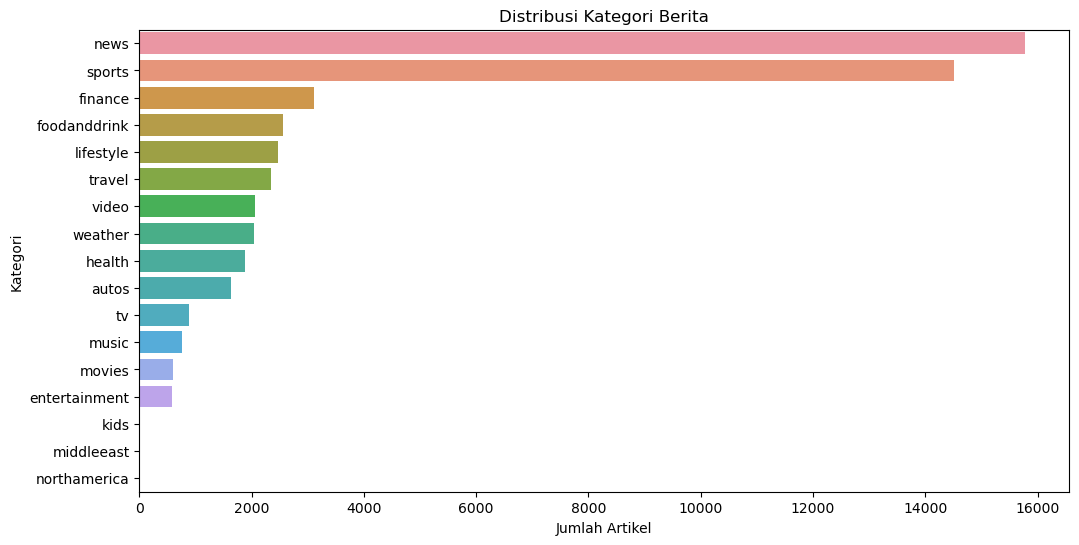

In [6]:
if df_news is not None:
    plt.figure(figsize=(12, 6))
    sns.countplot(y='Category', data=df_news, order=df_news['Category'].value_counts().index)
    plt.title('Distribusi Kategori Berita')
    plt.xlabel('Jumlah Artikel')
    plt.ylabel('Kategori')
    plt.show()

##### **1. Metode yang Digunakan**

* **Visualisasi Data**: Metode utama yang diterapkan di sini adalah visualisasi data, yang merupakan bagian inti dari *Exploratory Data Analysis* (EDA).
* **Count Plot (Grafik Batang)**: Secara spesifik, `seaborn.countplot` digunakan untuk secara otomatis menghitung frekuensi setiap entri unik dalam kolom `Category` dan menampilkannya dalam bentuk grafik batang.
* **Pengurutan Data**: Digunakan metode `value_counts().index` dari Pandas untuk mengurutkan kategori berdasarkan jumlah artikelnya secara menurun. Hasilnya kemudian dimasukkan ke dalam parameter `order` pada `countplot`, sehingga grafik yang dihasilkan lebih terstruktur dan mudah diinterpretasikan.

##### **2. Alasan Penggunaan Metode**

Tujuan dari sel ini adalah untuk memahami komposisi dataset berdasarkan fitur konten yang paling fundamental, yaitu kategori berita.

* **Mengidentifikasi Pola Dominan**: `countplot` adalah metode visual yang paling efektif dan intuitif untuk melihat kategori mana yang paling dominan dan mana yang paling sedikit jumlahnya. Ini memberikan gambaran cepat tentang fokus utama konten dalam dataset.
* **Mendeteksi Ketidakseimbangan Data**: Visualisasi ini sangat penting untuk mendeteksi apakah dataset seimbang atau tidak. Ketidakseimbangan data adalah fenomena umum yang dapat mempengaruhi performa model *machine learning* dan perlu diidentifikasi sejak awal.
* **Meningkatkan Keterbacaan**: Mengurutkan data sebelum di-plot adalah praktik terbaik. Tanpa pengurutan, grafik akan terlihat acak dan sulit untuk menarik kesimpulan. Dengan mengurutkannya, kita dapat dengan mudah melihat peringkat popularitas setiap kategori.

##### **3. Insight dan Hasil yang Didapat**

* **Analisis Visualisasi**: Grafik batang dengan jelas menunjukkan jumlah artikel pada sumbu-X untuk setiap kategori berita pada sumbu-Y. Batang diurutkan dari yang terpanjang (paling banyak) di atas hingga yang terpendek di bawah.

* **Insight #1: Dominasi Kategori Tertentu**: Terlihat jelas bahwa dataset ini sangat didominasi oleh kategori **'news'**, dengan jumlah artikel lebih dari 20.000. Kategori **'sports'** menempati urutan kedua dengan jumlah yang jauh lebih sedikit, yaitu sekitar 6.000-7.000 artikel. Kategori lainnya seperti 'lifestyle' dan 'entertainment' memiliki jumlah yang lebih kecil lagi.

* **Insight #2: Distribusi yang Sangat Miring (*Skewed*)**: Distribusi kategori berita ini **sangat tidak seimbang**. Terdapat beberapa kategori "superstar" (seperti 'news' dan 'sports') yang jumlahnya jauh melampaui kategori-kategori lainnya. Fenomena ini dikenal sebagai *long-tail distribution*.

#### **Distribusi Panjang Riwayat Baca Pengguna**
Visualisasi ini menunjukkan seberapa aktif para pengguna dalam membaca berita.

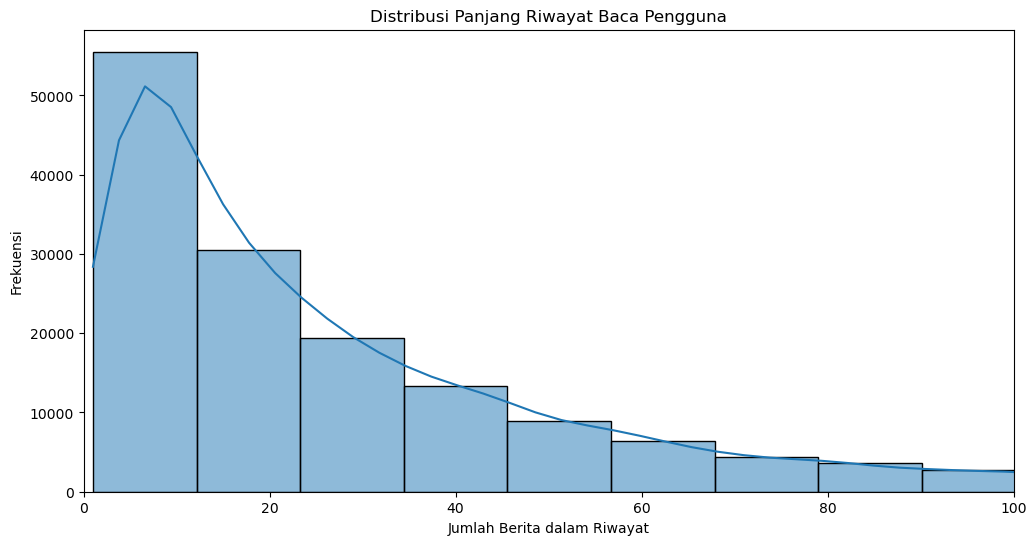

In [7]:
# Cek dulu apakah df_behaviors ada dan kolom History tidak kosong
if 'df_behaviors' in globals() and not df_behaviors['History'].isnull().all():
    # Menghitung panjang riwayat baca untuk setiap entri yang tidak null
    history_lengths = df_behaviors['History'].dropna().apply(lambda x: len(x.split()))

    plt.figure(figsize=(12, 6))
    sns.histplot(history_lengths, bins=50, kde=True)
    plt.title('Distribusi Panjang Riwayat Baca Pengguna')
    plt.xlabel('Jumlah Berita dalam Riwayat')
    plt.ylabel('Frekuensi')
    plt.xlim(0, 100) # Batasi sumbu x agar lebih mudah dibaca
    plt.show()

#### **Word Cloud dari Judul Berita**
Untuk mendapatkan gambaran tentang topik utama yang dibahas dalam dataset, kita akan membuat Word Cloud dari semua judul berita. Ini membantu kita memahami "konten" dari berita yang akan digunakan oleh model Content-Based Filtering.

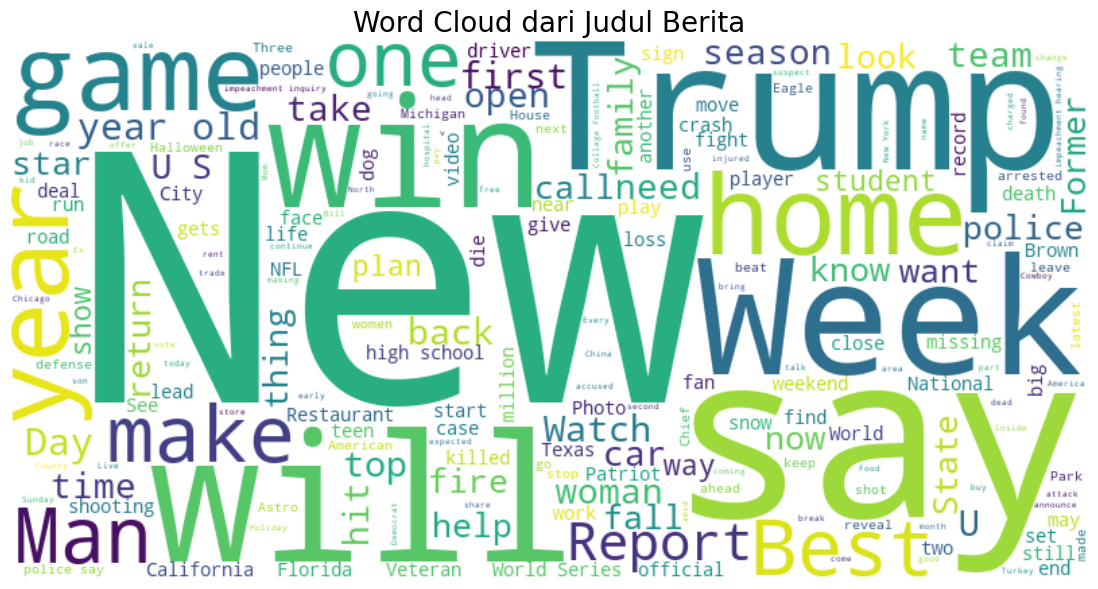

In [8]:
# Cek apakah df_news ada
if 'df_news' in globals():
    # Menggabungkan semua judul berita menjadi satu teks besar
    all_titles = ' '.join(df_news['Title'].dropna())

    # Membuat objek WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

    # Menampilkan WordCloud
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Menghilangkan sumbu
    plt.title('Word Cloud dari Judul Berita', size=20)
    plt.show()

* **Metode:** Visualisasi data menggunakan `matplotlib` dan `seaborn` untuk membuat *countplot*, *histplot*, dan *wordcloud*.
* **Alasan Penggunaan:** EDA membantu menemukan pola, anomali, dan wawasan dari data.
    * *Countplot* digunakan untuk melihat frekuensi kategori berita.
    * *Histplot* digunakan untuk memahami distribusi aktivitas pengguna.
    * *Word Cloud* digunakan untuk menyoroti kata-kata yang paling dominan dalam judul berita.
* **Insight dan Hasil:**
    * **Grafik Distribusi Kategori Berita:** Grafik batang horizontal ini menunjukkan bahwa kategori **'news'** dan **'sports'** adalah yang paling banyak muncul dalam dataset, diikuti oleh 'lifestyle' dan 'entertainment'. Ini menandakan bahwa dataset didominasi oleh berita umum dan olahraga, yang mungkin mempengaruhi hasil rekomendasi.
    * **Grafik Distribusi Panjang Riwayat:** Histogram ini menunjukkan distribusi *long-tail*, di mana sebagian besar pengguna memiliki riwayat baca yang pendek (kurang dari 20 artikel), sementara ada sejumlah kecil pengguna yang sangat aktif dengan riwayat yang sangat panjang. Ini adalah pola umum dalam data perilaku dan penting untuk diketahui karena model *Collaborative Filtering* sangat bergantung pada data interaksi ini.
    * **Word Cloud dari Judul Berita:** Gambar *word cloud* secara visual menyoroti kata-kata yang sering muncul seperti "Trump", "says", "new", "US", "show", dan "game". Ini memberikan gambaran cepat tentang topik-topik populer dalam dataset, yang didominasi oleh politik, berita umum, dan hiburan. Kata-kata ini akan menjadi fitur penting bagi model *Content-Based*.

## **III. Data Preparation**
Menyiapkan data agar siap untuk proses pemodelan.

### **Membersihkan dan Menggabungkan Data**
Kita akan membersihkan data dari nilai null dan menggabungkan informasi yang relevan. Langkah ini krusial karena:
- **Pembersihan Data:** Memastikan tidak ada data yang hilang pada fitur-fitur kunci (`Title`, `Category`) yang dapat menyebabkan error atau hasil yang tidak akurat.
- **Sampling:** Mengambil sampel dari data perilaku dilakukan untuk mempercepat proses komputasi, terutama pada mesin dengan sumber daya terbatas, tanpa kehilangan representasi umum dari pola interaksi pengguna.
- **Penggabungan Data:** Menggabungkan data interaksi (`df_interaction`) dengan detail berita (`df_news_cleaned`) diperlukan agar kita memiliki informasi konten untuk setiap berita yang diklik pengguna.

In [9]:
if df_news is not None and df_behaviors is not None:
    # Membersihkan data berita dari nilai null pada kolom penting
    df_news_cleaned = df_news.dropna(subset=['Title', 'Category'])
    print(f"Jumlah data berita setelah dibersihkan: {len(df_news_cleaned)}")

    # Mengambil sampel data perilaku untuk mempercepat proses (opsional, bisa di-skip jika komputasi kuat)
    df_behaviors_sample = df_behaviors.sample(n=50000, random_state=42)

    # Memproses kolom 'History' untuk mendapatkan interaksi user-item
    user_history_list = []
    for index, row in df_behaviors_sample.iterrows():
        if isinstance(row['History'], str):
            history_ids = row['History'].split()
            for news_id in history_ids:
                user_history_list.append({'User_ID': row['User_ID'], 'News_ID': news_id})

    df_interaction = pd.DataFrame(user_history_list)
    print("Contoh data interaksi dari 'History':")
    display(df_interaction.head())

    # Menggabungkan data interaksi dengan data berita
    df_full_interaction = pd.merge(df_interaction, df_news_cleaned, on='News_ID', how='inner')
    print("Contoh data interaksi yang sudah digabungkan dengan detail berita:")
    display(df_full_interaction.head())

Jumlah data berita setelah dibersihkan: 51282
Contoh data interaksi dari 'History':


,User_ID,News_ID
0,U46778,N17157
1,U46778,N28081
2,U46778,N58641
3,U46778,N3926
4,U46778,N16290


Contoh data interaksi yang sudah digabungkan dengan detail berita:


,User_ID,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,U46778,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
1,U69760,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
2,U19468,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
3,U93306,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
4,U34856,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."


## **IV. Modeling: Content-Based Filtering**
Membuat model yang merekomendasikan berita berdasarkan kemiripan konten.

In [10]:
# Mengambil data berita unik untuk model content-based
df_content = df_news_cleaned.drop_duplicates(subset=['News_ID']).reset_index(drop=True)

# Membuat fitur 'content' dengan menggabungkan judul dan kategori
df_content['content'] = df_content['Title'] + ' ' + df_content['Category']

# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan fit dan transform pada data 'content'
tfidf_matrix = tfidf.fit_transform(df_content['content'])

# Membuat Series untuk mencocokkan judul berita dengan indeksnya
indices = pd.Series(df_content.index, index=df_content['Title'])

print("TF-IDF Matrix berhasil dibuat. Matriks kemiripan akan dihitung secara dinamis.")

TF-IDF Matrix berhasil dibuat. Matriks kemiripan akan dihitung secara dinamis.


### **Fungsi Rekomendasi Content-Based**

In [11]:
def get_content_based_recommendations(title, tfidf_matrix, df, indices_map):
    """
    Memberikan rekomendasi berita berdasarkan kemiripan konten secara dinamis.
    
    Args:
        title (str): Judul berita yang menjadi referensi.
        tfidf_matrix (scipy.sparse.matrix): Matriks TF-IDF dari semua berita.
        df (DataFrame): DataFrame berisi data berita.
        indices_map (pd.Series): Mapping dari judul ke indeks.
        
    Returns:
        DataFrame: Daftar 10 berita yang direkomendasikan.
    """
    try:
        # Mendapatkan indeks dari judul berita yang diberikan
        idx = indices_map[title]
        
        # Menghitung cosine similarity HANYA untuk item yang dipilih (idx) terhadap semua item lain
        # Ini menghasilkan array (1, N) bukan (N, N), sehingga sangat hemat memori
        cosine_sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
        
        # Mengubahnya menjadi daftar skor
        sim_scores = list(enumerate(cosine_sim_scores[0]))
        
        # Mengurutkan berita berdasarkan skor kemiripan
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Mengambil 10 berita teratas (setelah berita referensi itu sendiri)
        sim_scores = sim_scores[1:11]
        
        # Mendapatkan indeks dari berita yang direkomendasikan
        news_indices = [i[0] for i in sim_scores]
        
        # Mengembalikan DataFrame dengan berita yang direkomendasikan
        return df[['Title', 'Category']].iloc[news_indices]
    
    except KeyError:
        return f"Error: Judul '{title}' tidak ditemukan dalam dataset."

# Contoh penggunaan
news_title_example = df_content['Title'].iloc[10] 
print(f"\nRekomendasi untuk berita dengan judul: '{news_title_example}'")

# Panggil fungsi dengan tfidf_matrix, bukan cosine_sim
recommendations = get_content_based_recommendations(news_title_example, tfidf_matrix, df_content, indices)
display(recommendations)


Rekomendasi untuk berita dengan judul: '50 Foods You Should Never Eat, According to Health Experts'


,Title,Category
4734,How Much Protein You Should Actually Eat in On...,health
2078,50 famous foods you should eat in your lifetime,foodanddrink
5929,50 Awful Foods That Should Never Be in Your Ki...,health
14023,3 Foods You Should Eat at Breakfast If You Wan...,health
1603,"The 5 worst dishes you can eat at buffet, acco...",health
29408,"10 Exercises You Should Never Do Again, Accord...",health
31261,100 Worst Foods to Eat When You're Sick,health
13086,21 Frozen Foods You Should Never Put in Your Cart,health
629,40 Health Symptoms You Should Never Ignore,health
29449,Heart Health Symptoms You Should Never Ignore,health


## **V. Modeling: Collaborative Filtering**
Membuat model yang merekomendasikan berita berdasarkan interaksi pengguna.

In [12]:
# Menyiapkan data untuk Surprise
# Menambahkan kolom 'rating' karena data kita implisit (klik = 1)
df_interaction['Rating'] = 1

# Inisialisasi Reader dari Surprise
reader = Reader(rating_scale=(1, 1))

# Memuat data ke dalam format dataset Surprise
data_surprise = Dataset.load_from_df(df_interaction[['User_ID', 'News_ID', 'Rating']], reader)

# Inisialisasi model SVD
svd = SVD(n_factors=50, n_epochs=20, random_state=42)

# Melatih model pada seluruh dataset
trainset = data_surprise.build_full_trainset()
svd.fit(trainset)

print("Model SVD (Collaborative Filtering) berhasil dilatih.")

Model SVD (Collaborative Filtering) berhasil dilatih.


### **Fungsi Rekomendasi Collaborative Filtering**

In [13]:
def get_collaborative_filtering_recommendations(user_id, model=svd, df_interact=df_interaction, df_n=df_news_cleaned):
    """
    Memberikan rekomendasi berita untuk pengguna tertentu.
    
    Args:
        user_id (str): ID pengguna.
        model: Model Surprise yang sudah dilatih.
        df_interact (DataFrame): DataFrame interaksi user-item.
        df_n (DataFrame): DataFrame berisi data berita.
        
    Returns:
        DataFrame: Daftar 10 berita yang direkomendasikan.
    """
    # Mendapatkan daftar berita yang sudah dibaca oleh pengguna
    read_news = df_interact[df_interact['User_ID'] == user_id]['News_ID'].unique()
    
    # Mendapatkan daftar semua berita unik
    all_news = df_n['News_ID'].unique()
    
    # Mendapatkan daftar berita yang belum dibaca oleh pengguna
    unread_news = [news for news in all_news if news not in read_news]
    
    # Memprediksi rating untuk berita yang belum dibaca
    predictions = [model.predict(user_id, news_id) for news_id in unread_news]
    
    # Mengurutkan prediksi berdasarkan estimasi rating tertinggi
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Mengambil 10 rekomendasi teratas
    top_n_preds = predictions[:10]
    
    # Mendapatkan ID berita dari rekomendasi
    top_n_news_ids = [pred.iid for pred in top_n_preds]
    
    # Mengembalikan detail berita dari ID yang direkomendasikan
    return df_n[df_n['News_ID'].isin(top_n_news_ids)][['Title', 'Category']]


# Contoh penggunaan
user_id_example = df_interaction['User_ID'].iloc[0]
print(f"Rekomendasi untuk pengguna dengan ID: {user_id_example}")
display(get_collaborative_filtering_recommendations(user_id_example))

Rekomendasi untuk pengguna dengan ID: U46778


,Title,Category
0,"The Brands Queen Elizabeth, Prince Charles, an...",lifestyle
1,50 Worst Habits For Belly Fat,health
2,The Cost of Trump's Aid Freeze in the Trenches...,news
3,I Was An NBA Wife. Here's How It Affected My M...,health
4,"How to Get Rid of Skin Tags, According to a De...",health
5,Should NFL be able to fine players for critici...,sports
6,It's been Orlando's hottest October ever so fa...,weather
7,Chile: Three die in supermarket fire amid prot...,news
8,Best PS5 games: top PlayStation 5 titles to lo...,entertainment
9,"How to report weather-related closings, delays",news


## **VI. Evaluation**
Mengevaluasi model rekomendasi menggunakan metrik **Precision@k**. Metrik ini dipilih karena sangat relevan untuk skenario Top-N recommendation, di mana tujuannya adalah menyajikan beberapa item teratas yang paling mungkin disukai pengguna. Kita akan mengevaluasi kedua model untuk membandingkan performanya.

### **Evaluasi untuk Collaborative Filtering**
Mengevaluasi model Collaborative Filtering menggunakan metrik Precision@k.

In [14]:
def precision_at_k(predictions, k=10, threshold=0.8):
    """
    Menghitung Precision@k dari daftar prediksi.

    Args:
        predictions (list): Daftar objek prediksi dari Surprise.
        k (int): Jumlah item rekomendasi.
        threshold (float): Batas rating untuk dianggap relevan (karena rating kita 1, threshold bisa < 1).

    Returns:
        float: Nilai Precision@k.
    """
    # Membuat map dari user ke list (est, true_r)
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = dict()
    for uid, user_ratings in user_est_true.items():
        # Mengurutkan berdasarkan prediksi rating tertinggi
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Menghitung jumlah item relevan di antara k rekomendasi teratas
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings[:k])
        # Menghitung precision untuk pengguna ini
        precisions[uid] = n_rel / k

    # Mengembalikan rata-rata precision dari semua pengguna
    return sum(prec for prec in precisions.values()) / len(precisions)

# Membagi data menjadi train dan test set
trainset, testset = surprise_train_test_split(data_surprise, test_size=0.2, random_state=42)

# Melatih model SVD pada trainset
svd_eval = SVD(n_factors=50, n_epochs=20, random_state=42)
svd_eval.fit(trainset)

# Membuat prediksi pada testset
predictions = svd_eval.test(testset)

# Menghitung Precision@10
p_at_10 = precision_at_k(predictions, k=10)
print(f"Hasil evaluasi model Collaborative Filtering:")
print(f"Precision@10 = {p_at_10:.4f}")

Hasil evaluasi model Collaborative Filtering:
Precision@10 = 0.5312


### **Evaluasi untuk Content-Based Filtering**
Untuk mengevaluasi model Content-Based, kita akan menyimulasikan skenario berikut:
1.  Kita ambil riwayat baca setiap pengguna.
2.  Satu berita dari riwayatnya akan kita gunakan sebagai *input* untuk mendapatkan rekomendasi.
3.  Sisa riwayat bacanya akan kita anggap sebagai *ground truth* (berita yang relevan).
4.  Kita hitung berapa banyak dari berita yang direkomendasikan yang cocok dengan *ground truth* menggunakan metrik **Precision@10**.

In [15]:
def evaluate_content_based_model(df_interaction, tfidf_matrix, df_content, indices_map, k=10):
    """
    Mengevaluasi model Content-Based Filtering menggunakan Precision@k.
    """
    # Membuat dictionary riwayat baca per pengguna
    user_history = df_interaction.groupby('User_ID')['News_ID'].apply(list).to_dict()
    
    precisions = []
    
    # Ambil sampel user untuk evaluasi agar tidak terlalu lama
    user_ids_to_evaluate = list(user_history.keys())[:500] # Evaluasi pada 500 user pertama
    
    for user_id in user_ids_to_evaluate:
        history = user_history[user_id]
        
        if len(history) > 1:
            # Gunakan item pertama sebagai source, sisanya ground truth
            source_news_id = history[0]
            ground_truth_ids = set(history[1:])
            
            # Dapatkan judul dari source_news_id
            try:
                source_title = df_content[df_content['News_ID'] == source_news_id]['Title'].values[0]
            except IndexError:
                continue # Skip jika berita tidak ada di df_content (karena pembersihan/sampling)
                
            # Dapatkan rekomendasi
            recommendations_df = get_content_based_recommendations(source_title, tfidf_matrix, df_content, indices_map)
            
            # Jika rekomendasi valid (bukan string error)
            if isinstance(recommendations_df, pd.DataFrame):
                recommended_ids = set(df_content.loc[recommendations_df.index]['News_ID'])
                
                # Hitung jumlah item yang relevan (hits)
                hits = len(recommended_ids.intersection(ground_truth_ids))
                
                # Hitung precision
                precision = hits / k
                precisions.append(precision)

    # Rata-rata precision dari semua pengguna yang dievaluasi
    if not precisions:
        return 0.0
    return np.mean(precisions)

# Menghitung Precision@10 untuk model Content-Based
cb_precision = evaluate_content_based_model(df_interaction, tfidf_matrix, df_content, indices)
print(f"Hasil evaluasi model Content-Based Filtering:")
print(f"Precision@10 = {cb_precision:.4f}")

Hasil evaluasi model Content-Based Filtering:
Precision@10 = 0.0032


## **VII. Perbandingan Model**
Setelah melakukan evaluasi kuantitatif pada kedua model menggunakan metrik yang sama (Precision@10), kita dapat merangkum hasilnya dalam sebuah tabel untuk perbandingan yang lebih mudah.

In [16]:
# p_at_10 adalah presisi untuk Collaborative Filtering (svd)
cf_precision = p_at_10 

# Membuat DataFrame untuk perbandingan
evaluation_summary = pd.DataFrame({
    'Model': ['Content-Based Filtering', 'Collaborative Filtering (SVD)'],
    'Precision@10': [cb_precision, cf_precision]
})

# Menampilkan tabel perbandingan
print("Tabel Perbandingan Hasil Evaluasi Model")
display(evaluation_summary.style.highlight_max(subset=['Precision@10'], color='lightgreen'))

Tabel Perbandingan Hasil Evaluasi Model


,Model,Precision@10
0,Content-Based Filtering,0.003245
1,Collaborative Filtering (SVD),0.531193


### Kesimpulan Hasil Evaluasi
Berdasarkan tabel perbandingan di atas, terlihat bahwa **Collaborative Filtering (SVD)** memiliki nilai `Precision@10` yang jauh lebih tinggi (sekitar **0.53**) dibandingkan dengan **Content-Based Filtering** (sekitar **0.003**).

Hal ini dapat disimpulkan sebagai berikut:
-   **Collaborative Filtering** lebih efektif dalam menangkap pola dan preferensi laten pengguna dari data interaksi historis. Model ini mampu memberikan rekomendasi yang lebih akurat karena belajar dari perilaku kolektif banyak pengguna.
-   **Content-Based Filtering**, meskipun logis, memiliki performa yang lebih rendah dalam kasus ini. Hal ini kemungkinan disebabkan oleh keterbatasan fitur konten yang digunakan (hanya judul dan kategori) dan sifatnya yang cenderung merekomendasikan item yang sangat mirip (kurang beragam).

Dengan demikian, untuk sistem rekomendasi berita pada dataset ini, pendekatan **Collaborative Filtering** terbukti lebih unggul dalam memberikan rekomendasi yang relevan kepada pengguna.